In [35]:

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from scipy.interpolate import griddata

In [36]:
path = '/home/amouche/data/cyclobs/rotated_files/'
##file = 's1b-iw-owi-cm-20201031t212858-20201031t213128-000003-02DBDB_ll_gd_rotated.nc'
file = 's1a-ew-owi-cm-20201029t205631-20201029t205758-000003-0415BC_ll_gd_rotated.nc'
#file = 's1a-ew-owi-cm-20201030t092540-20201030t092711-000003-0415F8_ll_gd_rotated.nc'
#file = 'rs2--owi-cm-20201030t211604-20201030t211719-00003-5CB2D_ll_gd_rotated.nc'
##file = 's1a-ew-owi-cm-20201103t103118-20201103t103249-000003-041800_ll_gd_rotated.nc'
file = 's1b-iw-owi-cm-20170923t104349-20170923t104554-000003-00D45F_ll_gd_rotated.nc'

In [37]:
ds = xr.open_dataset(path+file)
print(ds)

<xarray.Dataset>
Dimensions:                          (lat: 1000, lon: 1000, x: 1000, y: 1000)
Coordinates:
    x_coords                         (x, y) int64 ...
    y_coords                         (x, y) int64 ...
    r_polar                          (x, y) float64 ...
    theta                            (x, y) float64 ...
    lon_coords                       (lon, lat) float64 ...
    lat_coords                       (lon, lat) float64 ...
Dimensions without coordinates: lat, lon, x, y
Data variables:
    nrcs_co                          (x, y) float32 ...
    wind_from_direction              (x, y) float32 ...
    nrcs_cross                       (x, y) float32 ...
    nrcs_detrend_cross               (x, y) float32 ...
    wind_speed                       (x, y) float32 ...
    elevation_angle                  (x, y) float32 ...
    mask_flag                        (x, y) float32 ...
    nrcs_detrend_co                  (x, y) float32 ...
    heterogeneity_mask               (x, 

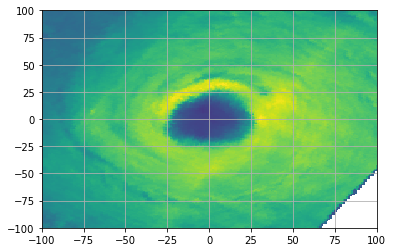

In [4]:
ws = np.array(ds['wind_speed'])
ra = np.array(ds['r_polar'])
th = np.mod(np.array(ds['theta'])*180./np.pi,360)
lon = np.array(ds['lon_coords'])
lat = np.array(ds['lat_coords'])
xx = np.array(ds['x_coords'])
yy = np.array(ds['y_coords'])
ws.shape
plt.pcolormesh(xx,yy,ws)
plt.axis([-100,100,-100,100]);plt.grid()

In [5]:
radius  = np.arange(501)+0.1
#radius[0] = 0.1
radius1 = radius*1.
azimuth = np.arange(361)
radius,azimuth = np.meshgrid(radius,azimuth)

spd_ = griddata((ra.flatten(),th.flatten()),ws.flatten(),(radius,azimuth))#,method='nearest')
xx_  = radius*np.cos(azimuth*np.pi/180.)
yy_  = radius*np.sin(azimuth*np.pi/180.)

In [6]:



#def loridan(r,X1,Y1,n,d,vmin,Rmax=radius1[np.argmax(spdm)],Vmax=np.nanmax(spdm)):
def loridan(r,X1,Y1,n,d,vmin,Rmax,Vmax):
    
    V=r*0
    Vinf = (Vmax-vmin)*((r)/Rmax)**n * np.exp((n-Rmax/X1)*(1-r/Rmax)) + vmin
    Vsup = Vmax**np.exp((-1)*((r-Rmax)/X1)*(r/Rmax)**Y1)
    V[r>Rmax] = Vsup[r>Rmax]
    V[r<=Rmax] = Vinf[r<=Rmax]
    return V



In [7]:
def azimuthal_modulation(XYin, a,b,c, alpha):
    
    azimuth,radius = XYin
    ss=1.
    
    AR = a + ss*b*radius + 0.*ss*c*radius**2.
    
    RR = AR*np.cos( (azimuth+alpha)*np.pi/180. )
    
    return RR
    
    

/home/amouche/miniconda3/envs/pyt3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/home/amouche/miniconda3/envs/pyt3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[367.44120797  -0.42602238  10.50373123  15.          14.12017378
  33.6775014   48.88951556]
[ 1.49648683  0.02883178  1.         21.07801023]


/home/amouche/miniconda3/envs/pyt3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


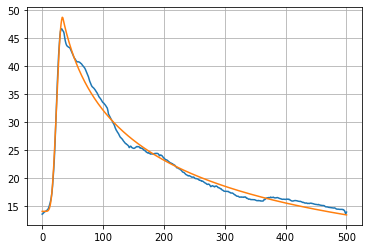

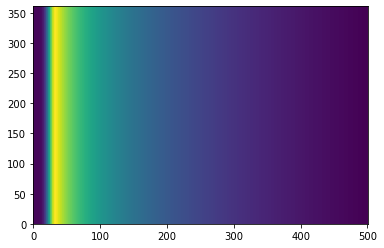

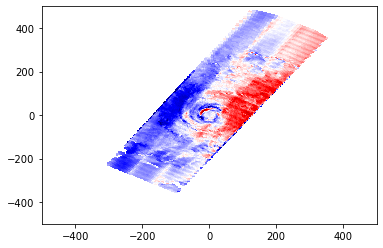

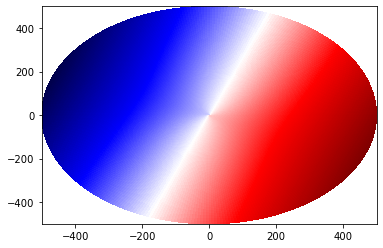

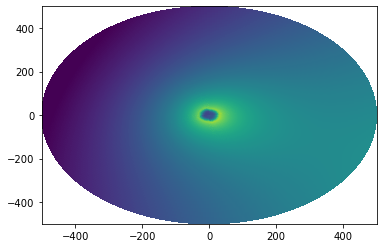

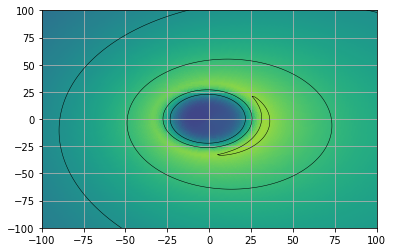

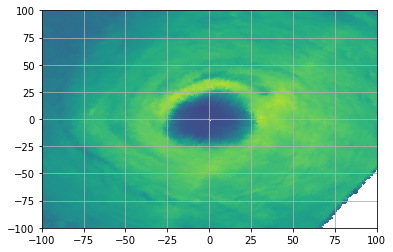

In [8]:
from scipy.optimize import curve_fit

#filtre = ~np.isnan(spd_) 
#XYin   = radius[filtre],azimuth[filtre]
#SPDin  = spd_[filtre]

spdm=np.nanmean(spd_,axis=0)


# Zeroth order =========================================

filtre = (~np.isnan(spdm.ravel())) #& (radius1<50)
XYin= radius1.ravel()[filtre]
SPDm = spdm.ravel()[filtre]
#
Vmax=np.nanmax(SPDm); Rmax=XYin[np.nanargmax(SPDm)]; X1=3*Rmax; Y1=-0.5; n=50  ; d=15; Vmin=np.nanmin(SPDm)
popt,pcov=curve_fit(loridan,XYin,SPDm,[X1,Y1,n,d,Vmin,Rmax,Vmax])
print(popt)

XYin= radius1.ravel()
spd0_1D = loridan(XYin,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])


fig=plt.figure()
plt.plot(radius1,spdm)
plt.plot(XYin,spd0_1D)
plt.grid()

spd0_2D = np.array([spd0_1D,]*361)

fig=plt.figure()
plt.pcolormesh(spd0_2D)



# First order =========================================

filtre = ~np.isnan(spd_) 
XYin = azimuth[filtre],radius[filtre]
eps_2D = (spd_-spd0_2D)
#
a=1; b=1; c=1; alpha=0
popt,pcov=curve_fit(azimuthal_modulation, XYin, eps_2D[filtre],[a,b,c,alpha])
print(popt)

XYin = azimuth,radius
spd1_2D = azimuthal_modulation(XYin, popt[0],popt[1],popt[2],popt[3])


fig=plt.figure()
plt.pcolormesh(xx_,yy_,eps_2D,cmap='seismic')


fig=plt.figure()
plt.pcolormesh(xx_,yy_,spd1_2D,cmap='seismic')

# Complete Vortex =========================================

spd_2D = spd0_2D + spd1_2D
fig=plt.figure()
plt.pcolormesh(xx_,yy_,spd_2D,vmin=0,vmax=60)


fig=plt.figure()
plt.pcolormesh(xx_,yy_,spd_2D,vmin=0,vmax=60)
plt.contour(xx_,yy_,spd_2D,colors='k',linewidths=0.5,levels=np.arange(30,100,10).tolist())
plt.axis([-100,100,-100,100]);plt.grid()
fig=plt.figure()
plt.pcolormesh(xx_,yy_,spd_,vmin=0,vmax=60)
plt.axis([-100,100,-100,100]);plt.grid()




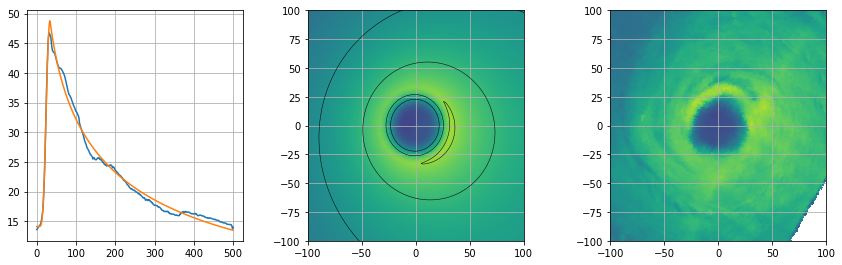

In [20]:
fig=plt.figure(figsize=(12,4))

axl = fig.add_axes([0.05, 0.1, 0.25, 0.8])
plt.plot(radius1,spdm)
plt.plot(radius1,spd0_1D)
plt.grid()

axc = fig.add_axes([0.375, 0.1, 0.25, 0.8])
plt.pcolormesh(xx_,yy_,spd_2D,vmin=0,vmax=60)
plt.contour(xx_,yy_,spd_2D,colors='k',linewidths=0.5,levels=np.arange(30,100,10).tolist())
plt.axis([-100,100,-100,100]);plt.grid()

axr = fig.add_axes([0.725, 0.1, 0.25, 0.8])
plt.pcolormesh(xx_,yy_,spd_,vmin=0,vmax=60)
plt.axis([-100,100,-100,100]);plt.grid()

plt.savefig('test.png')


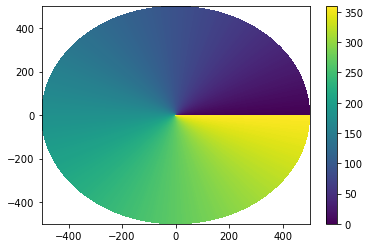

In [26]:
import os
'vortex_' + os.path.basename(file)[:-2] + '.png'


fig=plt.figure()
cs=plt.pcolormesh(xx_,yy_,azimuth)
plt.colorbar(cs)

In [34]:
radius.flatten()[np.argmax(spd_2D.flatten())]
spd_2D.flatten()[np.argmax(spd_2D.flatten())]-spd0_2D.flatten()[np.argmax(spd_2D.flatten())]

2.4508165173288177